In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import io
import re

In [2]:
def rename_cols_add_prefix(df, ignore=None, prefix='_', inplace=True):
  rename_f = lambda col : col if (ignore is not None and col in ignore) else prefix+col
  return df.rename(columns=rename_f, inplace=inplace)

# Preparação dos Dados de Entrada

## Extração dos Dados (Tipo 1)

Nesses arquivos, o formato do cabeçalho começa com 'YEAR', e depois possui colunas individuais para cada mês.

In [3]:
def extract_data_1(file_content):
    # Dividir o conteúdo em linhas
    lines = file_content.split('\n')
    
    # Encontrar o início dos dados (linha com YEAR, JAN, FEB, ...)
    start_index = next(i for i, line in enumerate(lines) if "YEAR" in line)
    
    # Encontrar o fim dos dados (primeira linha com 2024)
    end_index = next(i for i in range(start_index, len(lines)) if lines[i].startswith('2024'))
    
    # Extrair as linhas relevantes, incluindo o cabeçalho
    data_lines = lines[start_index:end_index+1]

    # Pré-processamento das linhas para garantir a correta separação de colunas
    processed_lines = []
    for line in data_lines:
        # Substituir -999.9 por espaços em branco
        line = re.sub(r'-999\.9', '      ', line)
        # Garantir que todos os campos sejam separados por pelo menos um espaço
        fields = re.split(r'\s+', line.strip())
        processed_line = ' '.join(fields)
        processed_lines.append(processed_line)
    
    # Criar um DataFrame
    df = pd.read_csv(io.StringIO('\n'.join(processed_lines)), sep=r'\s+', na_values=[''])
    
    return df

## Extração dos Dados (Tipo 2)

Nesses arquivos, o formato do cabeçalho começa com 'YR MON', em vez de possuir colunas individuais para cada mês.

In [4]:
def extract_data_2(file_content):
    # Dividir o conteúdo em linhas
    lines = file_content.split('\n')
    
    # Encontrar o início dos dados (linha do cabeçalho)
    start_index = next(i for i, line in enumerate(lines) if "YR MON" in line)
    
    # Encontrar o fim dos dados (última linha com 2024)
    end_index = next(i for i in range(len(lines)-1, start_index, -1) if lines[i].startswith('2024'))
    
    # Extrair as linhas relevantes, incluindo o cabeçalho
    data_lines = lines[start_index:end_index+1]

    # Pré-processamento das linhas para garantir a correta separação de colunas
    processed_lines = []
    for line in data_lines:
        # Substituir -999.9 por espaços em branco
        line = re.sub(r'-999\.9', '      ', line)
        # Garantir que todos os campos sejam separados por pelo menos um espaço
        fields = re.split(r'\s+', line.strip())
        processed_line = ' '.join(fields)
        processed_lines.append(processed_line)
    
    # Criar um DataFrame
    df = pd.read_csv(io.StringIO('\n'.join(processed_lines)), sep=r'\s+', na_values=[''])

    # Identificar colunas que contêm "ANOM"
    anomaly_columns = df.filter(like='ANOM').columns

    # Remover essas colunas do DataFrame
    df = df.drop(anomaly_columns, axis=1)
    
    return df

## Processamento dos Arquivos

Recebe todos os arquivos, separados por tipo, chama as funções para extrair os dataframes, e os salva em listas.

In [5]:
def process_files(file_list_1, file_list_2):
    dataframes_1 = []
    dataframes_2 = []

    # Processar arquivos do tipo 1
    for filename in file_list_1:
        with open(filename, 'r') as file:
            content = file.read()
        df = extract_data_1(content)
        dataframes_1.append(df)

    # Processar arquivos do tipo 2
    for filename in file_list_2:
        with open(filename, 'r') as file:
            content = file.read()
        df = extract_data_2(content)
        dataframes_2.append(df)

    return dataframes_1, dataframes_2

In [6]:
# Definição dos arquivos com formatos tipo 1 e tipo 2.
file_list_1 = [
    'dados/dados_in_new/cpac850.txt',
    'dados/dados_in_new/darwin.txt',
    'dados/dados_in_new/epac850.txt',
    'dados/dados_in_new/tahiti.txt',
    'dados/dados_in_new/wpac850.txt',
]

file_list_2 = [
    'dados/dados_in_new/sstoi.atl.indices.txt',
    'dados/dados_in_new/sstoi.indices.txt',
]

# Chama a função para extrair os dataframes
dfs1, dfs2 = process_files(file_list_1, file_list_2)

## Ajustes de Formato

Fazemos algumas alterações no formato dos dataframes para que possam ser unidos em um só mais facilmente.

In [7]:
# Função para renomear a coluna 'YR' para 'YEAR' (Tipo 2)
def rename_year_column(df):
    return df.rename(columns={'YR': 'YEAR'})

# Aplicar a função a cada DataFrame na lista
dfs2 = [rename_year_column(df) for df in dfs2]

# Função para alterar os meses em texto para o formato numérico (Tipo 1)
def change_months(df, vname):
    months_to_int = dict(JAN=1, FEB=2, MAR=3, APR=4, MAY=5, JUN=6, JUL=7, AUG=8, SEP=9, OCT=10, NOV=11, DEC=12)
    df = df.melt(id_vars=['YEAR'], var_name='MON', value_name=vname)
    df['MON'] = df['MON'].apply(lambda x : months_to_int[x])
    return df

# Aplicar a função a cada DataFrame na lista
dfs1[0] = change_months(dfs1[0], 'TW_CP')
dfs1[1] = change_months(dfs1[1], 'DarwinPr')
dfs1[2] = change_months(dfs1[2], 'TW_EP')
dfs1[3] = change_months(dfs1[3], 'TahitiPr')
dfs1[4] = change_months(dfs1[4], 'TW_WP')

## Merge Final

In [8]:
all_dfs = dfs1 + dfs2

for i, df in enumerate(all_dfs):
  if df is not None:
    rename_cols_add_prefix(df, ignore=['YEAR', 'MON'], prefix=str(i+1)+'_', inplace=True)

In [19]:
df_full_in = dfs1[0]
for df in all_dfs[1:]:
  if df is not None:
    df_full_in = df_full_in.merge(df, on=['YEAR', 'MON'], how='inner')

df_full_in.head()

,YEAR,MON,1_TW_CP,MAC_a,NAT_a,JP_a,SAL_a,SAL_RF_a,NAT_m,JP_m,REC_m,MAC_m,POR_m,SAL_m,CAN_m
0,2019,1,8.4,187.2,null,56.2,58.8,13.4,25.4,72.6,141.3,223.6,91.4,62.9,47
1,2020,1,8.9,0,171,36.4,92.8,null,184.7,28.1,56.6,5,8.1,101.6,34
2,2019,2,7.2,95.2,51.2,234.4,1.2,null,179,219.9,117.1,96,76.3,1.5,7.4
3,2020,2,8.9,null,182,123.8,37.6,null,202.4,138.4,84.5,null,172.3,40.2,54.7
4,2018,3,11.8,141.8,235.4,null,164.6,null,274.4,204.4,120.6,172.9,227.5,188.7,283.1


# Preparação dos Dados de Saída

## Extração e Tratamento dos Dados
Pegamos os arquivos .csv desorganizados e extraímos as informações importantes para o projeto.

In [10]:
def extract_data_out(file_content):
    
    # Carregar o CSV supondo que todos os dados estão na primeira coluna
    df = pd.read_csv(file_content, header=None, sep='\t')
    
    # Separar a primeira coluna em múltiplas colunas usando o delimitador correto
    df = df[0].str.split(';', expand=True)
    
    # Identificar a linha que contém o cabeçalho correto
    header = df.iloc[9]
    header.name = None
    
    # Atribuir os novos cabeçalhos ao DataFrame
    df.columns = header
    
    # Remover todas as linhas anteriores ao cabeçalho e a linha do cabeçalho duplicada
    df = df.drop(index=range(0, 10))
    df.reset_index(drop=True, inplace=True)
    
    df['Data Medicao'] = pd.to_datetime(df['Data Medicao'])
    
    # create new columns for year and month
    df['YEAR'] = df['Data Medicao'].dt.year
    df['MON'] = df['Data Medicao'].dt.month
    
    # reindex columns to put 'YEAR' and 'MON' as first two columns
    df = df.reindex(columns=['YEAR', 'MON'] + list(df.columns[:-2])).drop(columns='Data Medicao')

    # Renomeia e extrai apenas as colunas necessárias
    df = df.rename(columns={'PRECIPITACAO TOTAL, MENSAL (AUT)(mm)':'PRECIP'})
    df = df.rename(columns={'PRECIPITACAO TOTAL, MENSAL(mm)':'PRECIP'})
    df = df[['YEAR', 'MON', 'PRECIP']]
    
    return df

## Processamento dos Arquivos
Recebe todos os arquivos, separados por tipo de estação (automática ou manual), chama as funções para extrair os dataframes, e os salva em listas.

In [11]:
def process_files_2(file_list_1, file_list_2):
    dataframes_1 = []
    dataframes_2 = []

    # Processar arquivos do tipo 1
    for filename in file_list_1:
        df = extract_data_out(filename)
        dataframes_1.append(df)

    # Processar arquivos do tipo 2
    for filename in file_list_2:
        df = extract_data_out(filename)
        dataframes_2.append(df)

    return dataframes_1, dataframes_2

In [12]:
# Definição dos arquivos com formatos tipo 1 e tipo 2.
file_list_auto = [
    'dados/dados_out_new/automaticas/dados_A301_M_2004-12-21_2021-11-11.csv', # Recife -8,05	-34,95
    'dados/dados_out_new/automaticas/dados_A303_M_2003-02-24_2024-11-30.csv', # Maceió -9,55	-35,77
    'dados/dados_out_new/automaticas/dados_A304_M_2003-02-23_2024-11-30.csv', # Natal -5,83	-35,20	
    'dados/dados_out_new/automaticas/dados_A320_M_2007-07-20_2024-11-30.csv', # João Pessoa -7,16	-34,81
    'dados/dados_out_new/automaticas/dados_A401_M_2000-05-12_2024-11-30.csv', # Salvador -13,00	-38,50
    'dados/dados_out_new/automaticas/dados_A456_M_2018-03-09_2024-11-30.csv' # Salvador (Radio Farol) -12,80	-38,49
]

file_list_manual = [
    'dados/dados_out_new/convencionais/dados_82598_M_1970-01-01_2024-11-30.csv', # Natal -5,83	-35,20
    'dados/dados_out_new/convencionais/dados_82798_M_1970-01-01_2024-11-30.csv', # João Pessoa -7,09	-34,84	
    'dados/dados_out_new/convencionais/dados_82900_M_1970-01-01_2020-08-31.csv', # Recife (Curado) -8,05	-34,95
    'dados/dados_out_new/convencionais/dados_82994_M_1970-01-01_2021-04-07.csv', # Maceió -9,67	-35,70
    'dados/dados_out_new/convencionais/dados_82996_M_1970-01-01_2024-11-30.csv', # Porto de Pedras -9,16	-35,29
    'dados/dados_out_new/convencionais/dados_83229_M_1970-01-01_2024-11-30.csv', # Salvador (Ondina) -13,00	-38,50	
    'dados/dados_out_new/convencionais/dados_83398_M_1970-01-01_2021-07-30.csv' # Canavieiras -15,67	-38,95
]
# Chama a função para extrair os dataframes
dfs_auto, dfs_manual = process_files_2(file_list_auto, file_list_manual)

In [13]:
# Função para atribuir os nomes das estações aos dataframes.
def name_station(df, vname):
    df = df.rename(columns={'PRECIP':vname})
    return df

# Aplicar a função a cada DataFrame (tanto automáticos quanto manuais)
dfs_auto[0] = name_station(dfs_auto[0], 'REC_a')
dfs_auto[1] = name_station(dfs_auto[1], 'MAC_a')
dfs_auto[2] = name_station(dfs_auto[2], 'NAT_a')
dfs_auto[3] = name_station(dfs_auto[3], 'JP_a')
dfs_auto[4] = name_station(dfs_auto[4], 'SAL_a')
dfs_auto[5] = name_station(dfs_auto[5], 'SAL_RF_a')

dfs_manual[0] = name_station(dfs_manual[0], 'NAT_m')
dfs_manual[1] = name_station(dfs_manual[1], 'JP_m')
dfs_manual[2] = name_station(dfs_manual[2], 'REC_m')
dfs_manual[3] = name_station(dfs_manual[3], 'MAC_m')
dfs_manual[4] = name_station(dfs_manual[4], 'POR_m')
dfs_manual[5] = name_station(dfs_manual[5], 'SAL_m')
dfs_manual[6] = name_station(dfs_manual[6], 'CAN_m')

## Merge Final

In [14]:
all_dfs = dfs_auto + dfs_manual

df_full_out = dfs_auto[0]
for df in all_dfs[1:]:
    df_full_out = df_full_out.merge(df, on=['YEAR', 'MON'], how='outer')

# Trata os 'null', transformando-os em NaN
df_full_out.replace('null', np.nan, inplace=True)

# Força o tipo numérico em todos os valores do dataframe.
for col in df_full_out.columns[2:]:
    df_full_out[col] = pd.to_numeric(df_full_out[col], errors='coerce')

# Cria a coluna 'PRECIP', com a média da precipitação de todas as estações para aquele mês/ano.
df_full_out['PRECIP'] = df_full_out.iloc[:, 2:].mean(axis=1, skipna=True)

df_full_out

,YEAR,MON,REC_a,MAC_a,NAT_a,JP_a,SAL_a,SAL_RF_a,NAT_m,JP_m,REC_m,MAC_m,POR_m,SAL_m,CAN_m,PRECIP
0,1970,1,NaN,NaN,NaN,NaN,NaN,NaN,26.9,5.5,102.2,46.4,NaN,192.1,NaN,74.620000
1,1970,2,NaN,NaN,NaN,NaN,NaN,NaN,18.8,71.6,113.3,72.0,NaN,164.5,NaN,88.040000
2,1970,3,NaN,NaN,NaN,NaN,NaN,NaN,208.4,385.7,269.4,372.4,NaN,73.0,NaN,261.780000
3,1970,4,NaN,NaN,NaN,NaN,NaN,NaN,212.3,517.9,591.3,330.6,NaN,205.1,NaN,371.440000
4,1970,5,NaN,NaN,NaN,NaN,NaN,NaN,60.8,199.9,186.7,NaN,NaN,244.6,NaN,173.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,2024,7,NaN,229.0,NaN,171.0,90.6,52.8,217.9,172.6,NaN,NaN,133.6,94.0,NaN,145.187500
655,2024,8,NaN,68.2,NaN,58.2,124.6,123.2,34.2,71.2,NaN,NaN,48.5,138.6,NaN,83.337500
656,2024,9,NaN,67.6,17.0,42.2,51.0,51.8,15.9,48.2,NaN,NaN,28.8,51.7,NaN,41.577778
657,2024,10,NaN,15.0,12.6,9.2,19.0,56.4,14.3,6.8,NaN,NaN,10.2,19.2,NaN,18.077778


# Exploratory Data Analysis

Vamos começar fazendo algumas análises exploratórias para entender mais sobre os Datasets.

### Média de Precipitação Mensal

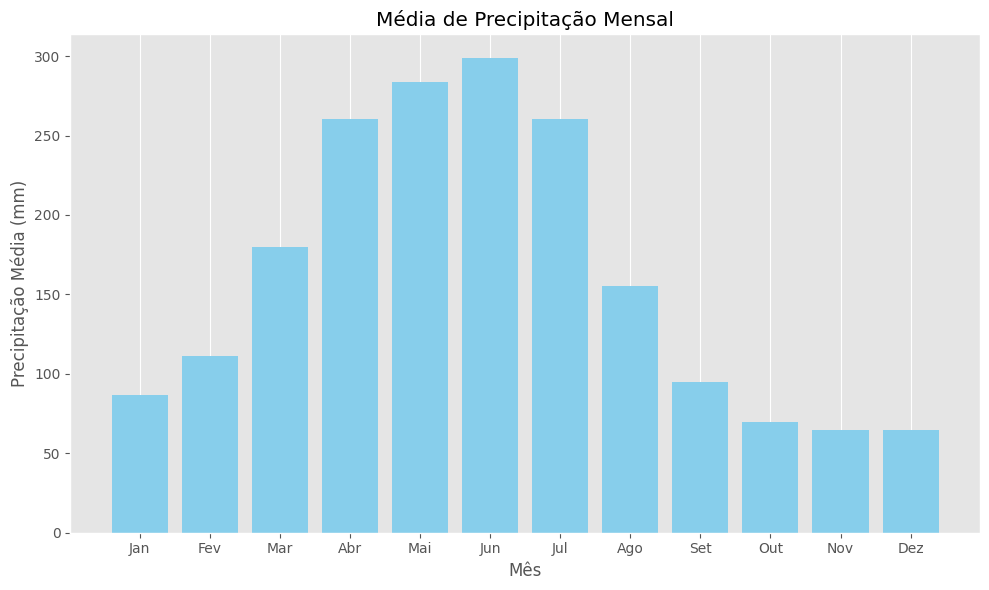

In [15]:
df1, df2 = df_full_in.copy(), df_full_out.copy()

# Calcular a média de precipitação por mês
precipitation_by_month = df_full_out.groupby('MON')['PRECIP'].mean().reset_index()

# Criar um gráfico de barras para a média de precipitação mensal
plt.figure(figsize=(10, 6))
plt.bar(precipitation_by_month['MON'], precipitation_by_month['PRECIP'], color='skyblue')
plt.title('Média de Precipitação Mensal')
plt.xlabel('Mês')
plt.ylabel('Precipitação Média (mm)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Correlação das Variáveis de Entrada com a Precipitação

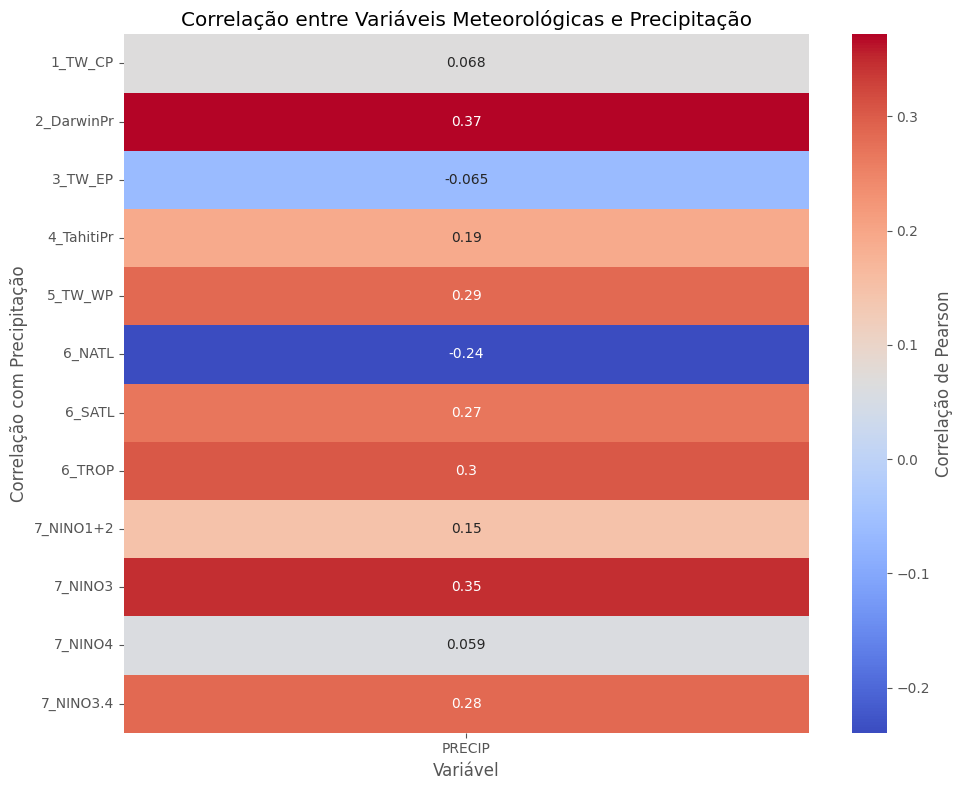

In [16]:
# Mesclar os DataFrames de entrada e saída
combined_df = pd.merge(df1, df2[['YEAR', 'MON', 'PRECIP']], on=['YEAR', 'MON'])

# Remover colunas não meteorológicas
combined_df = combined_df.drop(columns=['YEAR', 'MON'])

# Calcular a matriz de correlação
correlation_matrix = combined_df.corr()

# Focar nas correlações com a precipitação
precip_corr = correlation_matrix['PRECIP'].drop('PRECIP')

# Criar um mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(precip_corr.to_frame(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlação de Pearson'})
plt.title('Correlação entre Variáveis Meteorológicas e Precipitação')
plt.xlabel('Variável')
plt.ylabel('Correlação com Precipitação')
plt.tight_layout()
plt.show()

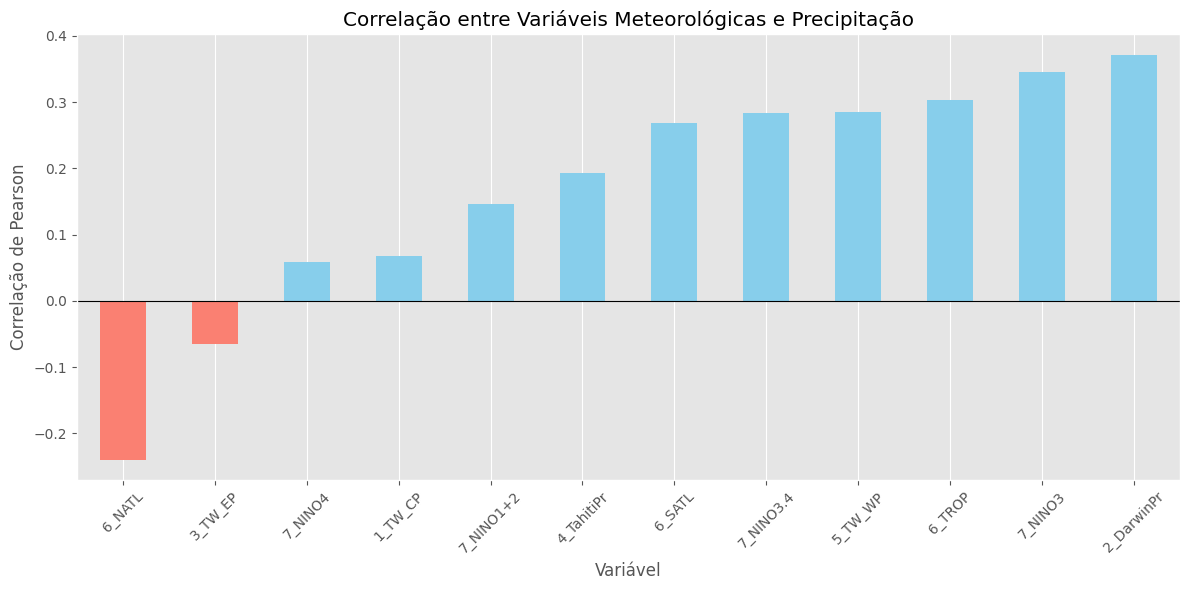

In [17]:
# Mesclar os DataFrames de entrada e saída
combined_df = pd.merge(df1, df2[['YEAR', 'MON', 'PRECIP']], on=['YEAR', 'MON'])

# Remover colunas não meteorológicas
combined_df = combined_df.drop(columns=['YEAR', 'MON'])

# Calcular a matriz de correlação
correlation_matrix = combined_df.corr()

# Focar nas correlações com a precipitação
precip_corr = correlation_matrix['PRECIP'].drop('PRECIP').sort_values()

# Plotar todas as correlações em um gráfico de barras
plt.figure(figsize=(12, 6))
colors = ['salmon' if val < 0 else 'skyblue' for val in precip_corr]
precip_corr.plot(kind='bar', color=colors)
plt.title('Correlação entre Variáveis Meteorológicas e Precipitação')
plt.xlabel('Variável')
plt.ylabel('Correlação de Pearson')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Visualização do Mapa

### Preparação dos Dados

In [18]:
# Caminho para o seu shapefile
shapefile_path = 'dados/BR_UF_2023/BR_UF_2023.shp'

# Ler o shapefile usando geopandas
gdf = gpd.read_file(shapefile_path)

gdf_nordeste = gdf[gdf['CD_REGIAO'] == '2']

# Filtrar estados com estações listadas
estados_litoraneos = ['BA', 'AL', 'PE', 'PB', 'RN']
gdf_litoral = gdf[gdf['SIGLA_UF'].isin(estados_litoraneos)]

# Mapear as estações para seus estados
estacoes_por_estado = {
    'PE': ['REC_a', 'REC_m'],
    'AL': ['MAC_a', 'MAC_m', 'POR_m'],
    'RN': ['NAT_a', 'NAT_m'],
    'PB': ['JP_a', 'JP_m'],
    'BA': ['SAL_a', 'SAL_RF_a', 'SAL_m', 'CAN_m'],
}

# Calcular a média geral de precipitação por estado
precip_estado = {}
for estado, estacoes in estacoes_por_estado.items():
    precip_estado[estado] = df_full_out[estacoes].mean().mean()

# Coordenadas das Estações
coord_auto = {
    'estacao': ['A301', 'A303', 'A304', 'A320', 'A401', 'A456'],
    'latitude': [-8.05, -9.55, -5.83, -7.16, -13.00, -12.80], 
    'longitude': [-34.95, -35.77, -35.20, -34.81, -38.50, -38.49]
}

coord_manual = {
    'estacao': ['82598', '82798', '82900', '82994', '82996', '83229', '83398'],
    'latitude': [-5.83, -7.09, -8.05, -9.67, -9.16, -13.00, -15.67], 
    'longitude': [-35.20, -34.84, -34.95, -35.70, -35.29, -38.50, -38.95]
}

# Criar um DataFrame com as médias
df_precip_estado = pd.DataFrame(list(precip_estado.items()), columns=['SIGLA_UF', 'precip_media'])

# Mesclar dados de precipitação com o GeoDataFrame
gdf_litoral = gdf_litoral.merge(df_precip_estado, on='SIGLA_UF', how='left')

DataSourceError: dados/BR_UF_2023/BR_UF_2023.shp: No such file or directory

### Plotagem

In [ ]:
# Criar o mapa coroplético
fig, ax = plt.subplots(figsize=(10, 8))
gdf_litoral.plot(column='precip_media', ax=ax, legend=True,
                 cmap='Blues', edgecolor='black')

# Destacar Sergipe sem cor (não possui estações dentre as da lista)
gdf_sergipe = gdf[gdf['SIGLA_UF'] == 'SE']
gdf_sergipe.plot(ax=ax, color='none', edgecolor='black', hatch='//')

# Adicionar marcadores de estações automáticas
plt.scatter(coord_auto['longitude'], coord_auto['latitude'], 
            color='blue', s=50, label='Automáticas', zorder=5)

# Adicionar marcadores de estações manuais
plt.scatter(coord_manual['longitude'], coord_manual['latitude'], 
            color='green', s=50, marker='s', label='Manuais', zorder=5)

# Configurar o título e rótulos
plt.title('Precipitação Média nos Estados Litorâneos do Nordeste')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Mostrar o mapa
plt.show()

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Realizar a junção interna com base nas colunas YEAR e MON
df = pd.merge(df_full_in, df_full_out, on=['YEAR', 'MON'], how='inner')

# Configurar YEAR e MON como índice
df.set_index(['YEAR', 'MON'], inplace=True)

# Separar os dados de entrada (features)
X = df.drop(columns=['PRECIP', 'REC_a', 'MAC_a', 'NAT_a', 'JP_a', 'SAL_a', 'SAL_RF_a', 'NAT_m', 'JP_m', 'REC_m', 'MAC_m', 'POR_m', 'SAL_m', 'CAN_m'])

# Separar a variável "target"
y = df['PRECIP']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_data, columns=X.columns)

scaled_df

In [ ]:
# Aplicar PCA
pca = PCA()
pca.fit(scaled_data)

# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Plotar o gráfico de cotovelo
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Gráfico de Cotovelo')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.grid()
plt.show()

# Decidir o número de componentes
# Por exemplo, para 95% de variância explicada
num_components = next(i for i, total_variance in enumerate(explained_variance.cumsum()) if total_variance >= 0.80) + 1
print(f"Escolha {num_components} componentes principais para capturar 80% da variância.")

In [ ]:
# Inicializar o PCA com o número de componentes desejado
pca = PCA(n_components=num_components)

# Ajustar o PCA aos dados escalados e transformá-los
principal_components = pca.fit_transform(scaled_data)

# Criar um DataFrame com os componentes principais
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])

# Mostrar a variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("Variância explicada por cada componente:", explained_variance)

pca_df.head()

In [ ]:
# Supondo que pca_df seja seu DataFrame com os componentes principais
sns.pairplot(pca_df)
plt.suptitle('Pair Plot dos Componentes Principais', y=1.02)
plt.show()

# Classificação

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

dfy = pd.DataFrame(y, columns=['PRECIP'])

plt.hist(df['PRECIP'], bins=30, color='skyblue')
plt.xlabel('Precipitação (mm)')
plt.ylabel('Frequência')
plt.title('Distribuição da Precipitação')
plt.show()

In [ ]:
median_precip = dfy['PRECIP'].median()

def categorize_precipitation(precip):
    if precip <= median_precip:
        return 'Baixa Precipitação'
    else:
        return 'Alta Precipitação'

# Aplicar a função para criar a nova coluna de classe
dfy['Precip_Class'] = dfy['PRECIP'].apply(categorize_precipitation)

dfy

In [ ]:
y = dfy['Precip_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar o tamanho dos conjuntos
print(f'Tamanho do conjunto de treino: {X_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inicializar o modelo de classificação
model = RandomForestClassifier(random_state=42)

# Treinar o modelo com os dados de treinamento
model.fit(X_train, y_train)

# Verificar se o treinamento foi concluído
print("Modelo treinado com sucesso!")

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

## Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

# Inicializar o modelo de Regressão Logística
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Treinar o modelo com os dados de treinamento
logistic_model.fit(X_train, y_train)

# Verificar se o treinamento foi concluído
print("Modelo treinado com sucesso!")

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = logistic_model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

## Rede Neural MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

# Inicializar o modelo MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Treinar o modelo com os dados de treinamento
mlp_model.fit(X_train, y_train)

# Verificar se o treinamento foi concluído
print("Modelo treinado com sucesso!")

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = mlp_model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializar o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo com os dados de treinamento
knn_model.fit(X_train, y_train)

# Verificar se o treinamento foi concluído
print("Modelo treinado com sucesso!")

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = knn_model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

## SVM

In [ ]:
from sklearn.svm import SVC

# Inicializar o modelo SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Treinar o modelo com os dados de treinamento
svm_model.fit(X_train, y_train)

# Verificar se o treinamento foi concluído
print("Modelo treinado com sucesso!")

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = svm_model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

## Overview

In [ ]:
# Função para calcular as métricas
def calculate_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted')
    }

# Modelos a serem avaliados
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'MLP': MLPClassifier(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'SVM': SVC(random_state=42)
}

# Calcular as métricas para cada modelo
metrics = {name: calculate_metrics(model, X_train, X_test, y_train, y_test) for name, model in models.items()}

# Preparar os dados para o gráfico
metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(models))
width = 0.2

# Criar o gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(14, 8))
for i, metric in enumerate(metric_names):
    values = [metrics[model][metric] for model in models]
    bars = ax.bar(x + i * width, values, width, label=metric.capitalize())
    
    # Adicionar os valores nas barras
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Configurações do gráfico
ax.set_xlabel('Modelos')
ax.set_ylabel('Pontuação')
ax.set_title('Comparação de Métricas dos Modelos de Classificação')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models.keys(), rotation=45)
ax.legend()

plt.tight_layout()
plt.show()